In [2]:
from pynini import *
import pandas as pd

# importing data

In [3]:
df = pd.DataFrame.from_csv('finnish_train.tsv', sep='\t', header=None, index_col=None)

In [33]:
df.head()

,LEMMA,WORDFORM,MORPHOLOGY
0,kvalifikaatio,kvalifikaatiossa,IN
1,kuolinnaamio,kuolinnaamiolla,AT
2,saali,saalissa,IN
3,pakenija,pakenijalla,AT
4,oppositiokansanedustaja,oppositiokansanedustajassa,IN


In [5]:
df.columns = ['LEMMA', 'WORDFORM', 'MORPHOLOGY']
df.head()

,LEMMA,WORDFORM,MORPHOLOGY
0,kvalifikaatio,kvalifikaatiossa,N;IN+ESS;SG
1,kuolinnaamio,kuolinnaamiolla,N;AT+ESS;SG
2,saali,saalissa,N;IN+ESS;SG
3,pakenija,pakenijalla,N;AT+ESS;SG
4,oppositiokansanedustaja,oppositiokansanedustajassa,N;IN+ESS;SG


In [6]:
df['MORPHOLOGY'] = df['MORPHOLOGY'].str.extract(r'([A-Z]{2})\+ESS')
df.head()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


,LEMMA,WORDFORM,MORPHOLOGY
0,kvalifikaatio,kvalifikaatiossa,IN
1,kuolinnaamio,kuolinnaamiolla,AT
2,saali,saalissa,IN
3,pakenija,pakenijalla,AT
4,oppositiokansanedustaja,oppositiokansanedustajassa,IN


# separating adessive and inessive

In [7]:
adessive = df.loc[df['MORPHOLOGY'] == 'AT']
inessive = df.loc[df['MORPHOLOGY'] == 'IN']

In [8]:
adessive.head(2)

,LEMMA,WORDFORM,MORPHOLOGY
1,kuolinnaamio,kuolinnaamiolla,AT
3,pakenija,pakenijalla,AT


In [9]:
inessive.head(2)

,LEMMA,WORDFORM,MORPHOLOGY
0,kvalifikaatio,kvalifikaatiossa,IN
2,saali,saalissa,IN


# building fst

In [10]:
all_chr = sorted(list(set(''.join(list(df['LEMMA'])+list(df['WORDFORM'])))))
all_chr

['-',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'v',
 'y',
 'ä',
 'ö',
 'š']

In [11]:
neutral = ['i', 'e']
front = ['y', 'ö', 'ä']
back = ['u', 'o', 'a']
consonant = [i for i in all_chr[1:] if i not in neutral and i not in front and i not in back]

In [12]:
fin_alphabet = string_map(all_chr).closure()
left_env = string_map(back) + string_map(neutral+consonant).closure()

In [13]:
fst_at_suffix = transducer('', 'llä')
fst_in_suffix = transducer('', 'ssä')
fst_vowelharm = transducer('ä', 'a')

In [14]:
add_at_suffix = cdrewrite(fst_at_suffix, '', '[EOS]', fin_alphabet)
add_in_suffix = cdrewrite(fst_in_suffix, '', '[EOS]', fin_alphabet)
vowel_harm = cdrewrite(fst_vowelharm, 
                       string_map(back)+string_map(neutral+consonant).closure()+string_map(['l','s']).closure(2), 
                       '[EOS]', fin_alphabet)

In [15]:
result_at = [compose(input_str, add_at_suffix@vowel_harm).stringify() for input_str in adessive['LEMMA']]
result_in = [compose(input_str, add_in_suffix@vowel_harm).stringify() for input_str in inessive['LEMMA']]

# output rules into .far file

In [16]:
with Far("MP1_finnish.far", "w") as sink:
    sink["ADESSIVE"] = add_at_suffix@vowel_harm
    sink["INESSIVE"] = add_in_suffix@vowel_harm

# assessment

In [17]:
adessive['RESULT'] = result_at
adessive['ASSESSMENT'] = (result_at == adessive['WORDFORM'])
inessive['RESULT'] = result_in
inessive['ASSESSMENT'] = (result_in == inessive['WORDFORM'])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [36]:
adessive.head()

,LEMMA,WORDFORM,MORPHOLOGY,RESULT,ASSESSMENT
1,kuolinnaamio,kuolinnaamiolla,AT,kuolinnaamiolla,True
3,pakenija,pakenijalla,AT,pakenijalla,True
6,abbedissa,abbedissalla,AT,abbedissalla,True
9,häkkikanala,häkkikanalalla,AT,häkkikanalalla,True
11,seurustelu,seurustelulla,AT,seurustelulla,True


In [29]:
len(adessive.loc[adessive['ASSESSMENT'] == False])

23

In [25]:
len(adessive.loc[adessive['ASSESSMENT'] == True])/len(adessive)

0.7012987012987013

In [31]:
len(inessive.loc[inessive['ASSESSMENT'] == False])

13

In [26]:
len(inessive.loc[inessive['ASSESSMENT'] == True])/len(inessive)

0.821917808219178

# what's in the .far file

In [21]:
with Far('MP1_finnish.far', 'r') as test:
    print(test)

<sttable Far 'MP1_finnish.far', mode 'r' at 0x117a55888>


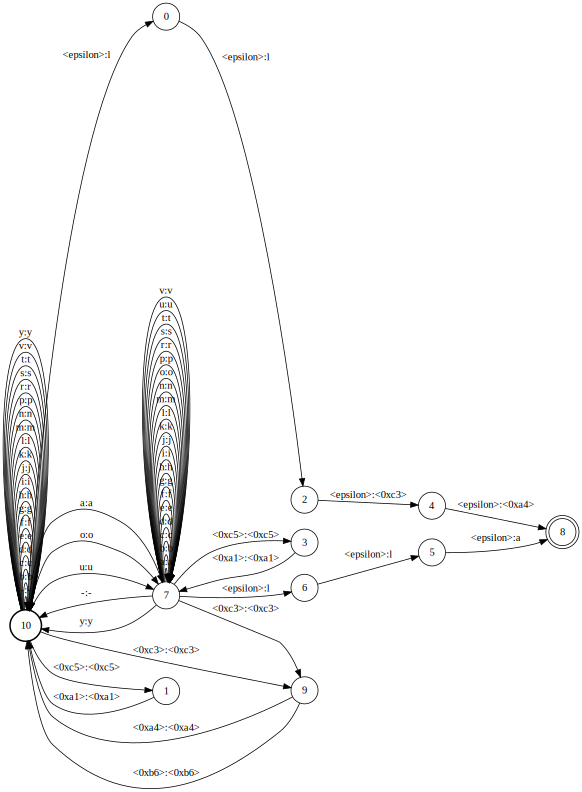

In [22]:
test['ADESSIVE'].optimize()

In [23]:
test.get_key()

'ADESSIVE'